In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.nanops import bottleneck_switch

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency, get_residuals_subdets_with_err, get_rays_in_sub_det_vectorized, get_rays_in_sub_det, get_raw_residuals, get_circle_scan, plot_2D_circle_scan

In [3]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dylan-MS-7C84':
    base_dir = '/media/ucla/Saclay/cosmic_data/'
    det_type_info_dir = '/home/dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/media/ucla/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dphnpct50.extra.cea.fr':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 0.2  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'rd542_strip_1_quick_tests_9-25-25'
run_dir = f'{base_dir}{run_name}/'
# sub_run_name = 'hour_run_resist_500V'
sub_run_name = 'quick_test_480V'

det_single = 'rd542_strip_1'

file_nums = list(range(0, 3))
# file_nums = list(range(0, 109))
# file_nums = 'all'

noise_sigma = 4

realign_dream = True  # If False, read alignment from file, if True, realign Dream detector
# realign_dream = False  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [15, 15]  # mm range to search for optimal z position
z_rot_align_range = [-2, 2]

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [4]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums, chi2_cut=1.5)
print(f'{len(ray_data.ray_data)} rays')

Getting ray data...


100%|██████████| 1/1 [00:00<00:00, 134.91it/s]

Cutting on detector size: 2306 / 4704 tracks remain, 49.02%
Pre-chi2 cut, Found 2402 events with 0 good tracks (51.06%), 3 events with >1 good tracks (0.06%)
Found 3457 events with 0 good tracks (73.49%), 0 events with >1 good tracks (0.00%)
1247 rays


Getting no cut ray data...


100%|██████████| 1/1 [00:00<00:00, 59.60it/s]


4704 rays, fraction remaining: 26.51%


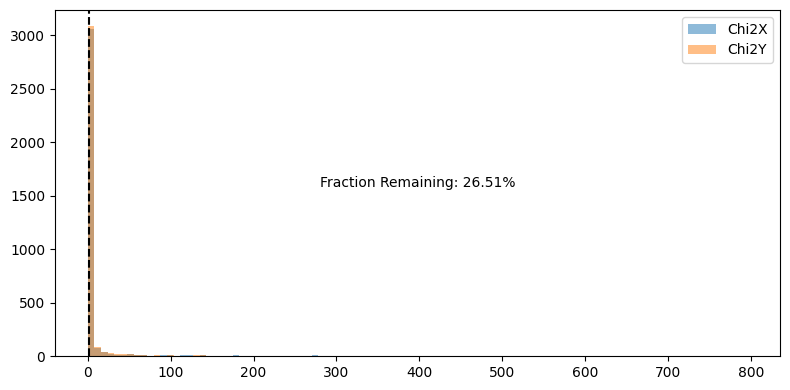

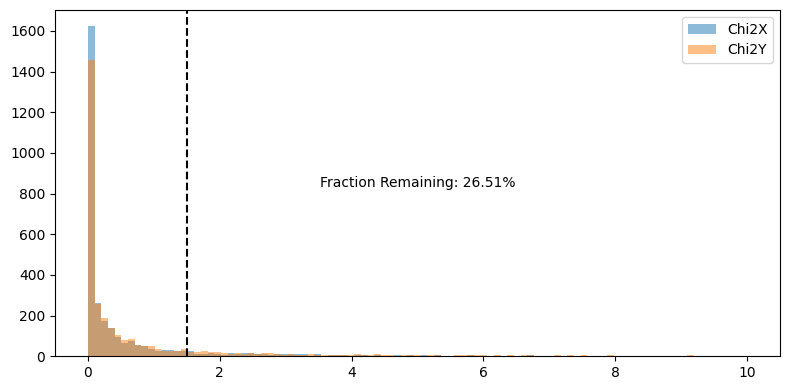

In [5]:
print(f'Getting no cut ray data...')
ray_data_no_cut = M3RefTracking(m3_dir, single_track=False, file_nums=file_nums)
fraction_remaining = len(ray_data.ray_data) / len(ray_data_no_cut.ray_data)
print(f'{len(ray_data_no_cut.ray_data)} rays, fraction remaining: {fraction_remaining * 100:.2f}%')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2X'], axis=1), bins=100, alpha=0.5, label='Chi2X')
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2Y'], axis=1), bins=100, alpha=0.5, label='Chi2Y')
ax.axvline(ray_data_no_cut.chi2_cut, color='black', ls='--')
ax.annotate(f'Fraction Remaining: {fraction_remaining * 100:.2f}%', (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
ax.legend()
fig.tight_layout()

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2X'], axis=1), bins=np.linspace(0, 10, 100), alpha=0.5, label='Chi2X')
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2Y'], axis=1), bins=np.linspace(0, 10, 100), alpha=0.5, label='Chi2Y')
ax.axvline(ray_data_no_cut.chi2_cut, color='black', ls='--')
ax.annotate(f'Fraction Remaining: {fraction_remaining * 100:.2f}%', (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
ax.legend()
fig.tight_layout()

In [6]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [7]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')

det.load_dream_data(data_dir, ped_dir, noise_sigma, file_nums, chunk_size, hist_raw_amps=True, save_waveforms=True, waveform_fit_func='parabola_vectorized')
print(f'Hits shape: {det.dream_data.hits.shape}')

Found 4 groups in detector map
FEU Num: 6
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 800, 'resist_1': 480, 'resist_2': 480}
Reading in data...
Getting sub chunk 1/5, events: 0-940 of 4704


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Read in data shape: (940, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 718.96it/s]


Fitting time: 0.027925968170166016 s
Processed sub-chunk 1/5
Getting sub chunk 2/5, events: 940-1881 of 4704


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Read in data shape: (941, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 529.25it/s]


Fitting time: 0.026599884033203125 s
Processed sub-chunk 2/5
Getting sub chunk 3/5, events: 1881-2822 of 4704


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Read in data shape: (941, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 1316.24it/s]


Fitting time: 0.026372909545898438 s
Processed sub-chunk 3/5
Getting sub chunk 4/5, events: 2822-3763 of 4704


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Read in data shape: (941, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 1080.85it/s]


Fitting time: 0.03173494338989258 s
Processed sub-chunk 4/5
Getting sub chunk 5/5, events: 3763-4704 of 4704


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Read in data shape: (941, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 708.33it/s]

Fitting time: 0.028847217559814453 s
Processed sub-chunk 5/5
Processed chunk 1/1
Getting hits...
Hits shape: (4704, 256)


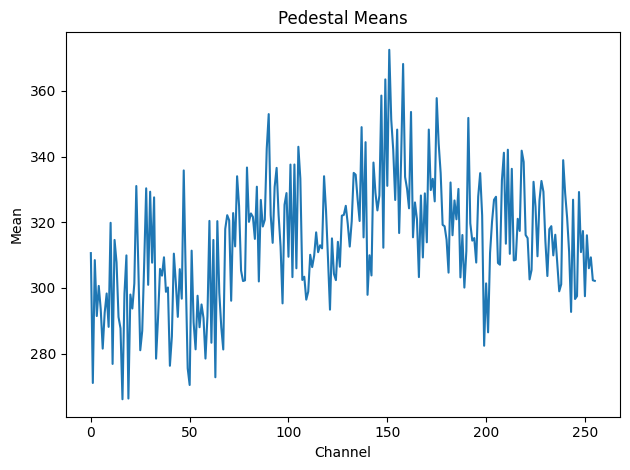

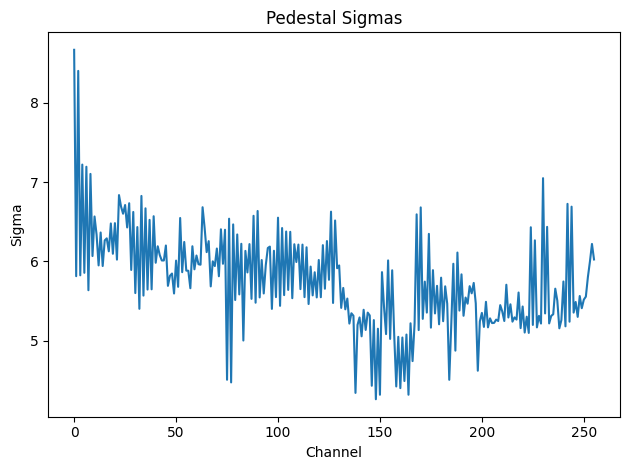

In [8]:
det.dream_data.plot_pedestals()

/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:774: RuntimeWarning: All-NaN slice encountered
  event_max_amps = np.nanmax(self.data_amps, axis=1)


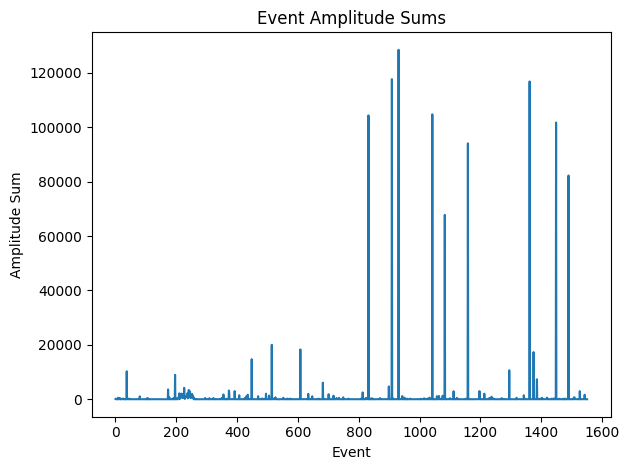

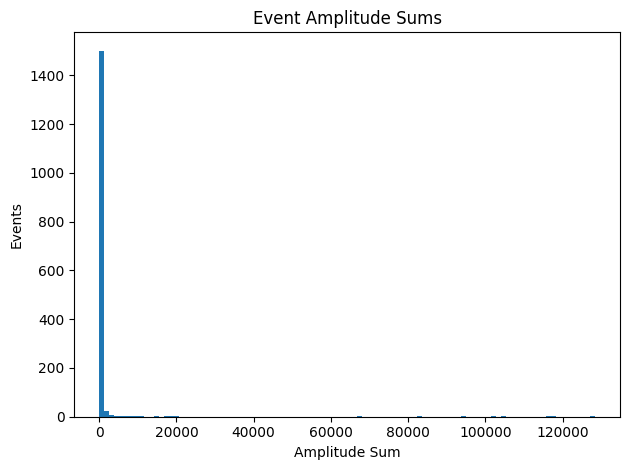

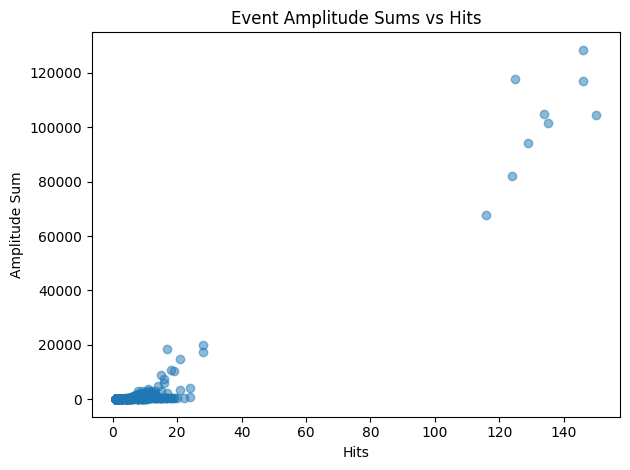

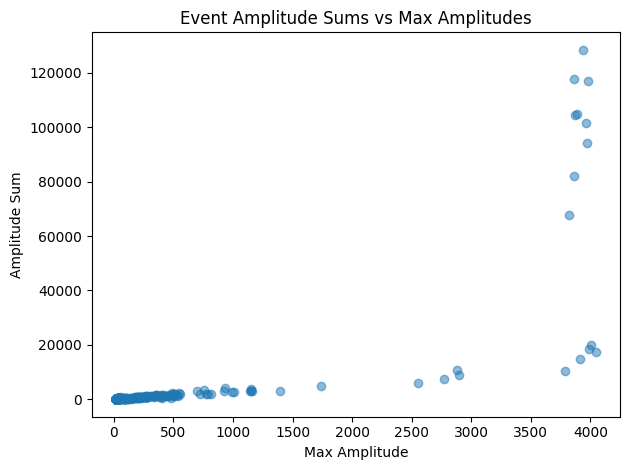

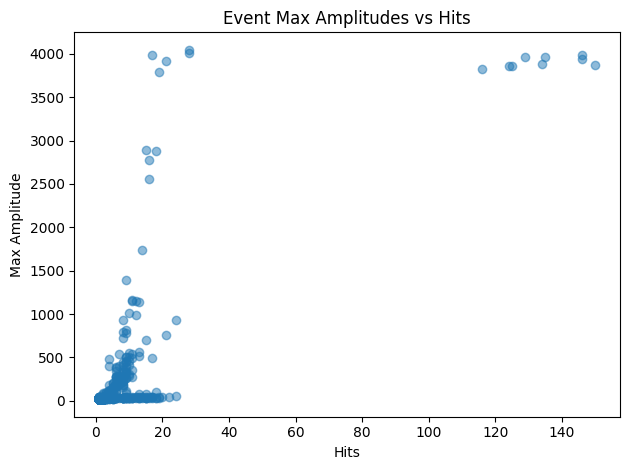

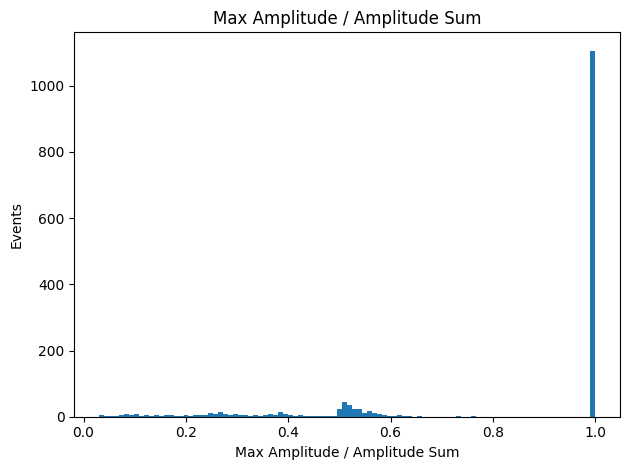

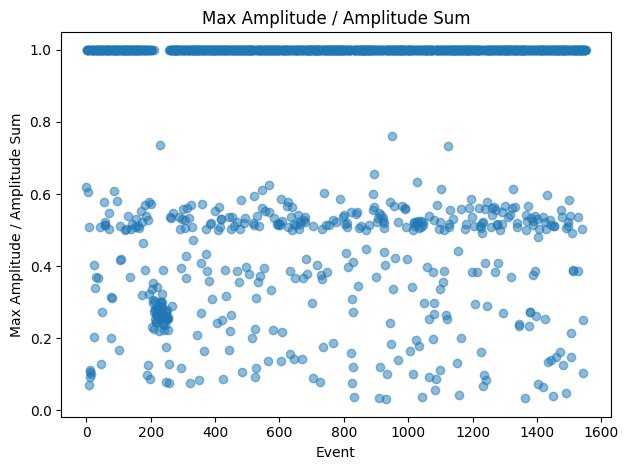

In [9]:
det.dream_data.plot_noise_metric()

Connector 1 Dead Strips: []
Connector 2 Dead Strips: []
Connector 3 Dead Strips: [170]
Connector 4 Dead Strips: []


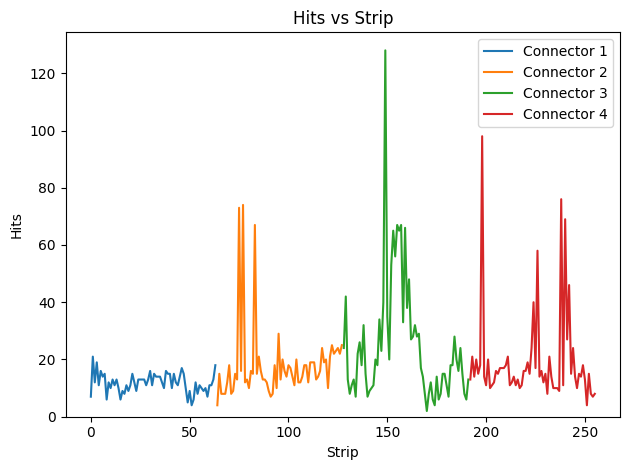

In [10]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

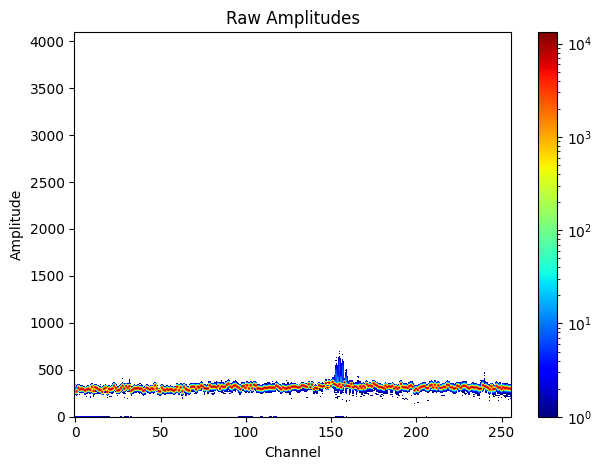

In [11]:
det.dream_data.plot_raw_amps_2d_hist()

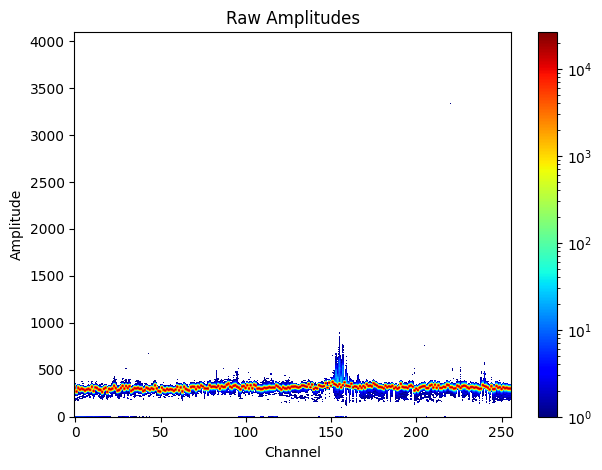

In [12]:
det.dream_data.plot_raw_amps_2d_hist(combine_y=2)

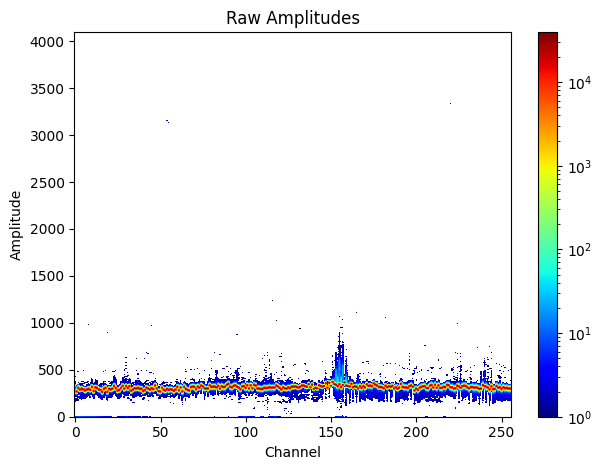

In [13]:
det.dream_data.plot_raw_amps_2d_hist(combine_y=3)

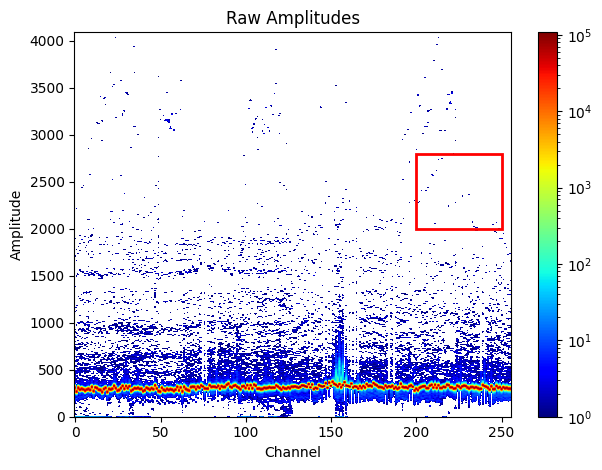

In [14]:
channel_range = (200, 250)
amplitude_range = (2000, 2800)
det.dream_data.plot_raw_amps_2d_hist(combine_y=10)

# Add a rectangle around channel/amplitude range
rect = plt.Rectangle((channel_range[0], amplitude_range[0]), channel_range[-1] - channel_range[0], amplitude_range[-1] - amplitude_range[0], fill=False, color='red', linewidth=2)
plt.gca().add_patch(rect)

In [15]:
from matplotlib.colors import LogNorm
def plot_raw_amps_2d_hist(data, bin_size: int = 16):
    """
    Plot a 2D histogram of amplitudes vs. channel.

    Parameters
    ----------
    data : np.ndarray
        Array of shape (n_events, 256, n_samples).
    bin_size : int
        Bin size for amplitudes (default=16). Range is 0–4096.
    """
    if data.ndim != 3 or data.shape[1] != 256:
        raise ValueError("Input must have shape (n_events, 256, n_samples)")

    n_events, n_channels, n_samples = data.shape

    # Flatten samples and events for each channel → shape (n_events * n_samples, 256)
    flat_data = data.reshape(-1, n_channels)

    # Define bins along amplitude axis
    bins = np.arange(0, 4096 + bin_size, bin_size)
    n_bins_y = len(bins) - 1

    # Build histogram (vectorized)
    hist = np.zeros((n_channels, n_bins_y), dtype=np.int64)
    for ch in range(n_channels):
        hist[ch], _ = np.histogram(flat_data[:, ch], bins=bins)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Raw Amplitudes")
    ax.set_xlabel("Channel")
    ax.set_ylabel("Amplitude [ADC counts]")

    cmap = plt.cm.jet
    cmap.set_under('w')

    h = ax.imshow(
        hist.T,
        origin='lower',
        aspect='auto',
        cmap=cmap,
        extent=[-0.5, n_channels - 0.5, bins[0], bins[-1]],
        norm=LogNorm(vmin=1)
    )

    cbar = fig.colorbar(h, ax=ax)
    cbar.set_label("Counts (log scale)")
    fig.tight_layout()

In [16]:
print(det.dream_data.waveforms.shape)

(4704, 256, 32)


(4704, 256, 32)
(150528, 256)
(4704,)
(256, 288)
(256, 150240)


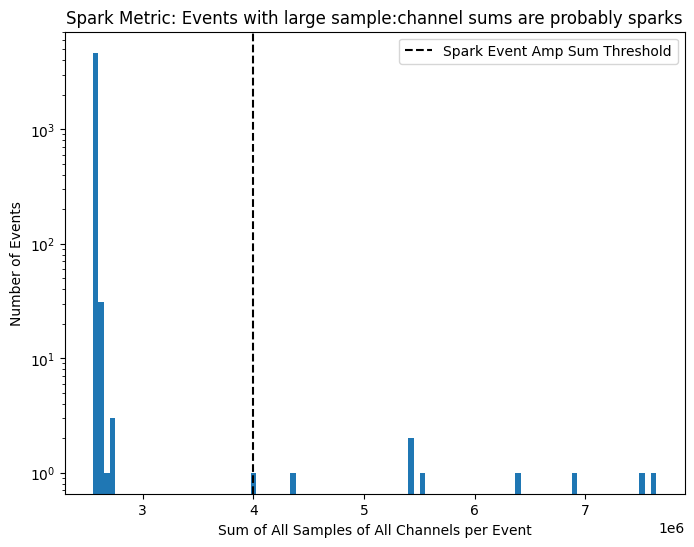

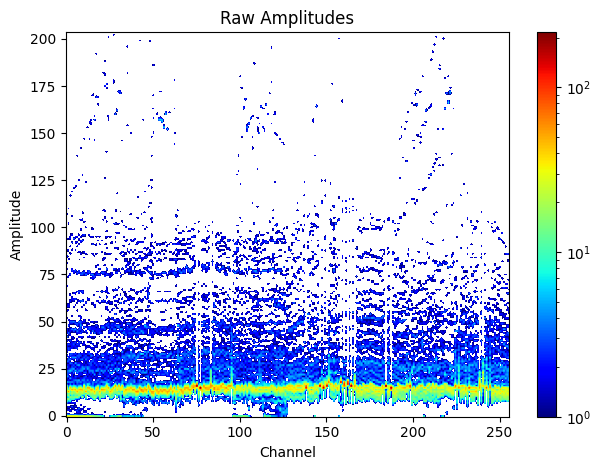

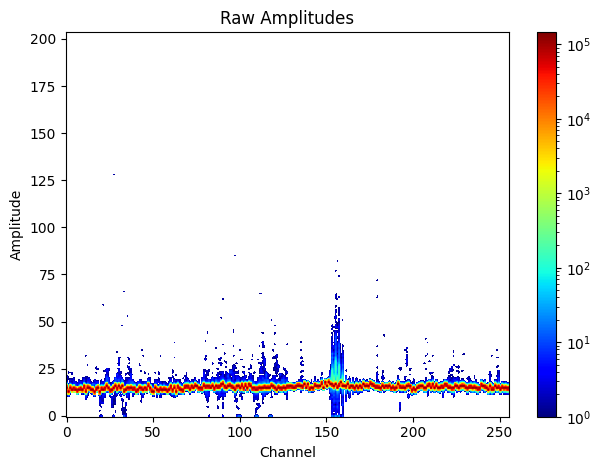

In [17]:
flat_data = det.dream_data.waveforms.reshape(-1, 256)
print(det.dream_data.waveforms.shape)
print(flat_data.shape)

waveforms = det.dream_data.waveforms
event_sums = np.sum(waveforms, axis=(1, 2))
print(event_sums.shape)

spark_event_amp_sum_thresh = 0.4e7
spark_event_filter = event_sums > spark_event_amp_sum_thresh

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(event_sums, bins=100)
ax.axvline(spark_event_amp_sum_thresh, color='black', ls='--', label='Spark Event Amp Sum Threshold')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Sum of All Samples of All Channels per Event')
ax.set_ylabel('Number of Events')
ax.set_title('Spark Metric: Events with large sample:channel sums are probably sparks')

spark_waveforms = waveforms[spark_event_filter]
non_spark_waveforms = waveforms[~spark_event_filter]

n_events, n_channels, n_samples = spark_waveforms.shape
data_raw_i = spark_waveforms.transpose(1, 0, 2).reshape(n_channels, n_events * n_samples)
bins_y = np.arange(-0.5, 4096.5, 20)
print(data_raw_i.shape)

histograms = np.array([np.histogram(data_raw_i[i], bins=bins_y)[0] for i in range(n_channels)])

fig, ax = plt.subplots()
ax.set_title(f'Raw Amplitudes')
ax.set_xlabel('Channel')
ax.set_ylabel('Amplitude')

cmap = plt.cm.jet
cmap.set_under('w')

n_channels, n_bins_y = histograms.shape
h = ax.imshow(
    histograms.T,
    origin='lower',
    aspect='auto',
    cmap=cmap,
    extent=[-0.5, n_channels - 0.5, -0.5, n_bins_y - 0.5],
    norm=LogNorm(vmin=1)
)

cbar = fig.colorbar(h, ax=ax)
fig.tight_layout()

n_events, n_channels, n_samples = non_spark_waveforms.shape
data_raw_i = non_spark_waveforms.transpose(1, 0, 2).reshape(n_channels, n_events * n_samples)
bins_y = np.arange(-0.5, 4096.5, 20)
print(data_raw_i.shape)

histograms = np.array([np.histogram(data_raw_i[i], bins=bins_y)[0] for i in range(n_channels)])

fig, ax = plt.subplots()
ax.set_title(f'Raw Amplitudes')
ax.set_xlabel('Channel')
ax.set_ylabel('Amplitude')

cmap = plt.cm.jet
cmap.set_under('w')

n_channels, n_bins_y = histograms.shape
h = ax.imshow(
    histograms.T,
    origin='lower',
    aspect='auto',
    cmap=cmap,
    extent=[-0.5, n_channels - 0.5, -0.5, n_bins_y - 0.5],
    norm=LogNorm(vmin=1)
)

cbar = fig.colorbar(h, ax=ax)
fig.tight_layout()

Text(0.5, 1.0, 'Spark Metric: Events with large sample:channel sums are probably sparks')

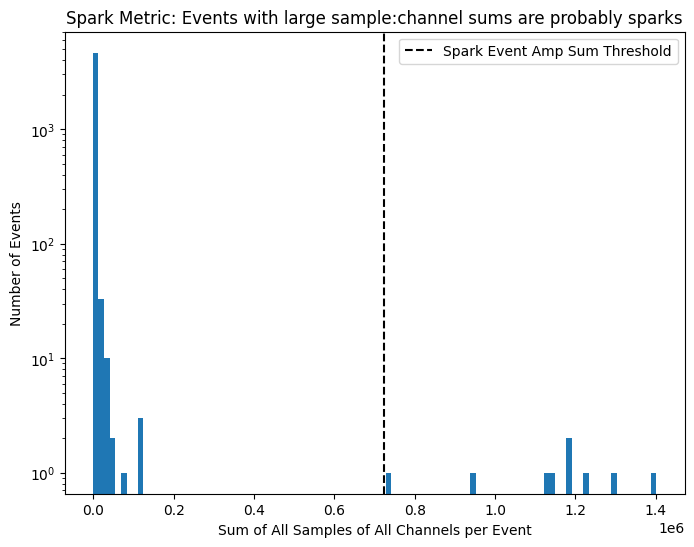

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(det.dream_data.event_amp_sums, bins=100)
ax.axvline(spark_event_amp_sum_thresh - 400 * 4 * 64 * 32, color='black', ls='--', label='Spark Event Amp Sum Threshold')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Sum of All Samples of All Channels per Event')
ax.set_ylabel('Number of Events')
ax.set_title('Spark Metric: Events with large sample:channel sums are probably sparks')

In [19]:
select_events_mask = (det.dream_data.event_amp_sums > 0.2e6) & (det.dream_data.event_amp_sums < 0.4e6)
select_event_nums = det.dream_data.event_nums[select_events_mask]
print(select_event_nums)

[]


In [20]:
print(f'Spark Waveforms: {spark_waveforms.shape}')
print(f'Non-Spark Waveforms: {non_spark_waveforms.shape}')

Spark Waveforms: (9, 256, 32)
Non-Spark Waveforms: (4695, 256, 32)


In [21]:
print(det.dream_data.waveforms.shape)
sample_filter = (det.dream_data.waveforms < amplitude_range[-1]) & (det.dream_data.waveforms > amplitude_range[0])
strip_filter = np.sum(sample_filter, axis=-1)
event_filter = np.sum(strip_filter[:, channel_range[0]:channel_range[-1]], axis=-1)
print(event_filter.shape)
print(event_filter > 0)
events = np.arange(0, len(event_filter))[event_filter > 0]
print(events)
print(len(events))
# [180:190]>1500 <2000


(4704, 256, 32)
(4704,)
[False False False ... False False False]
[ 125  576 2544 2575 2642 2979 3110 3867 4113 4508]
10


In [22]:
spark_event_nums = det.dream_data.event_nums[spark_event_filter]
print(spark_event_nums)
len(spark_event_nums)

[2351. 2576. 2643. 2980. 3111. 3381. 4114. 4370. 4509.]


9

In [23]:
det.make_sub_detectors()

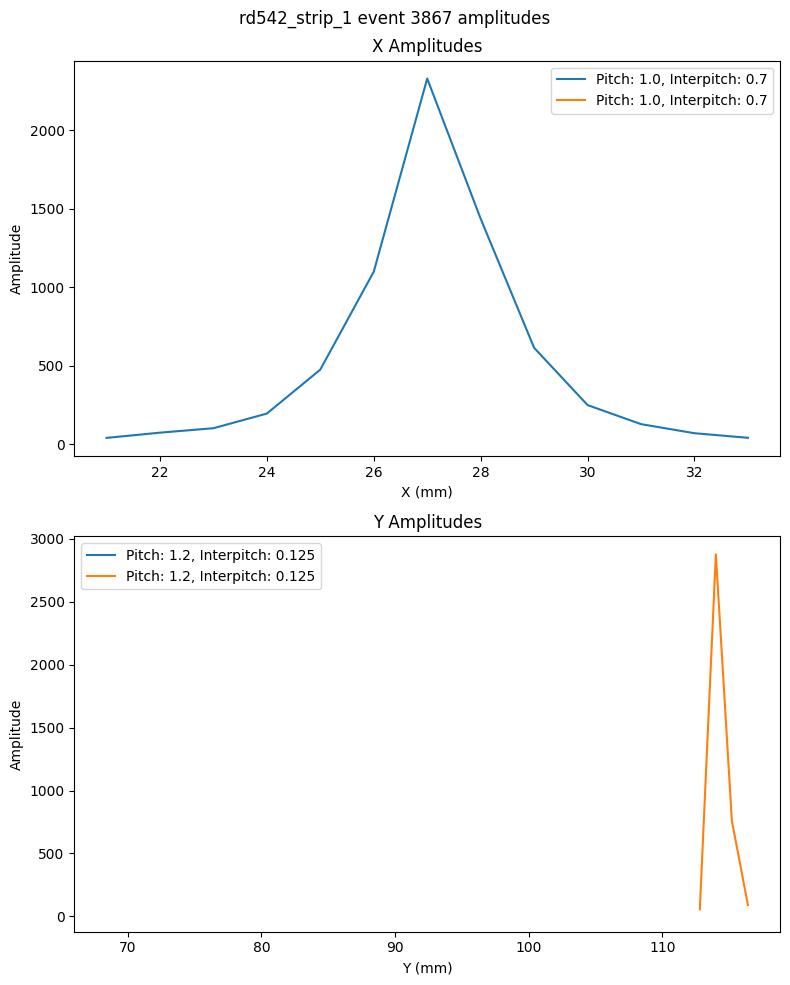

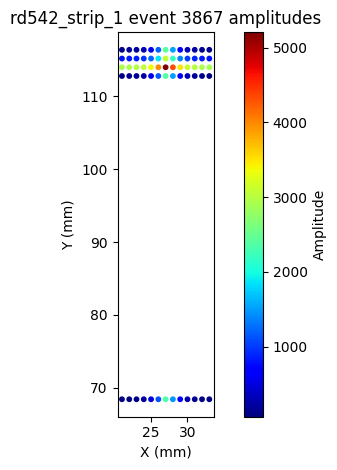

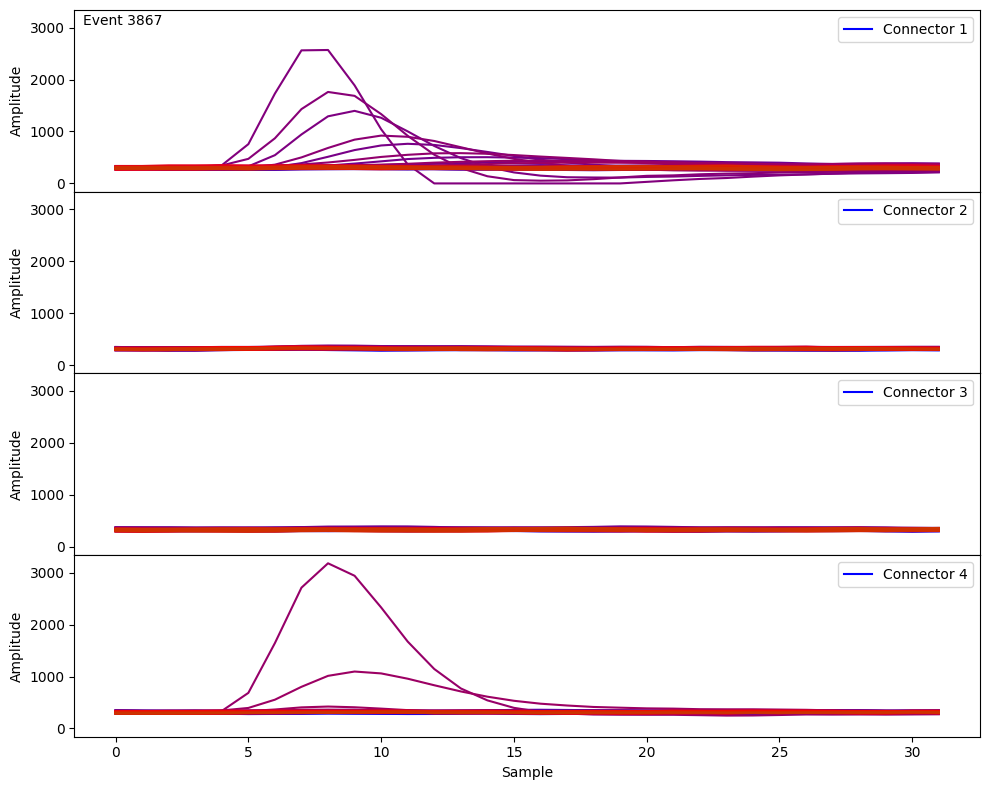

In [25]:
event_num = events[7]
# event_num = 9550 - 1
det.plot_event_1d(event_num)
det.plot_event_2d(event_num)
det.dream_data.plot_waveforms(event_num)

In [26]:
from DreamData import fit_waveform_parabola_vectorized, calc_parabola_vertex_new
waveform_e0_s0 = det.dream_data.waveforms[0][0]
print(waveform_e0_s0)

[314. 318. 328. 326. 320. 311. 306. 301. 303. 305. 304. 303. 311. 315.
 318. 320. 313. 303. 304. 304. 299. 299. 304. 310. 316. 311. 310. 306.
 315. 311. 309. 310.]


array([328.66666667,   2.33333333,   1.        ])

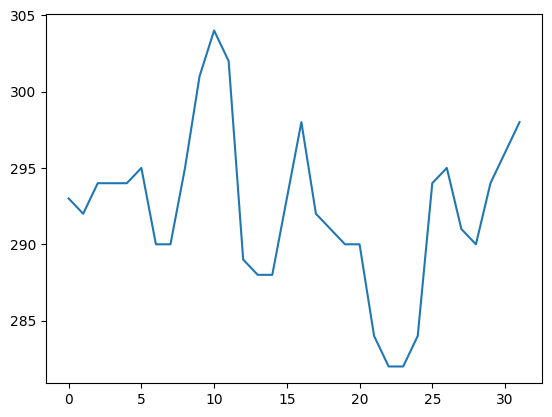

In [27]:
fig, ax = plt.subplots()
ax.plot(det.dream_data.waveforms[0][3])
fit_waveform_parabola_vectorized(det.dream_data.waveforms[0][0])

In [28]:
def fit_waveform_parabola_vectorized(data):
    max_indices = np.argmax(data, axis=-1)
    amplitudes = np.max(data, axis=-1)

    # Identify valid indices (exclude borders)
    valid_mask = (max_indices > 0) & (max_indices < data.shape[-1] - 1)

    # Gather x and y values for parabola fitting
    x_left = max_indices - 1
    x_mid = max_indices
    x_right = max_indices + 1

    # Keep left and right indices within bounds
    x_left = np.clip(x_left, 0, data.shape[-1] - 1)
    x_right = np.clip(x_right, 0, data.shape[-1] - 1)

    y_left = np.take_along_axis(data, x_left[..., None], axis=-1).squeeze(-1)
    y_mid = amplitudes
    y_right = np.take_along_axis(data, x_right[..., None], axis=-1).squeeze(-1)

    # Fit parabola for valid points only
    xv, yv = np.full(y_mid.shape, np.nan), np.full(y_mid.shape, np.nan)
    xv[valid_mask], yv[valid_mask] = calc_parabola_vertex_new(
        x_left[valid_mask], y_left[valid_mask],
        x_mid[valid_mask], y_mid[valid_mask],
        x_right[valid_mask], y_right[valid_mask]
    )

    xv[~valid_mask], yv[~valid_mask] = np.nan, np.nan

    success = valid_mask & (yv > 0)  # Optional condition for valid fits
    return np.stack([yv, xv, success], axis=-1)

In [29]:
fit_waveform_parabola_vectorized(det.dream_data.waveforms[0][3])

array([304.025,  10.1  ,   1.   ])

In [30]:
det.dream_data.data_fit_success[0][3]

np.False_

In [31]:
res = fit_waveform_parabola_vectorized(det.dream_data.waveforms[:3])

In [32]:
print(res[0][3])

[304.025  10.1     1.   ]


In [33]:
# for event_num in range(min(len(det.dream_data.hits), 2)):
#     det.plot_event_1d(event_num)
#     det.plot_event_2d(event_num)
#     det.dream_data.plot_waveforms(event_num)

In [34]:
print(det.dream_data.data_amps.shape)

(4704, 256)


In [35]:
sample_maxes = np.max(det.dream_data.waveforms, axis=-1)

In [36]:
np.sum(sample_maxes > 1000)

np.int64(2045)

In [37]:
print(np.sum(det.dream_data.data_amps > 1000))

323


In [38]:
np.sum(det.dream_data.raw_amp_hist[:, 1300:]) / 32

np.float64(350.5)

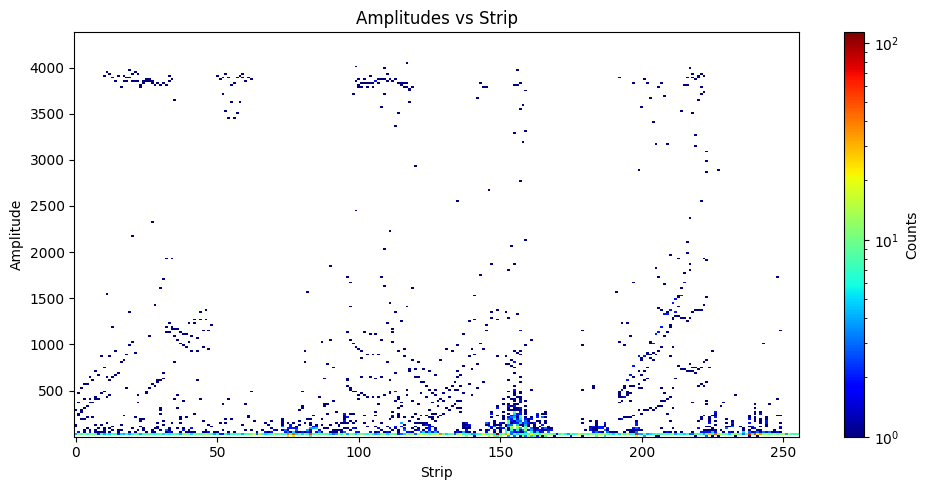

In [39]:
det.dream_data.plot_amplitudes_vs_strip()

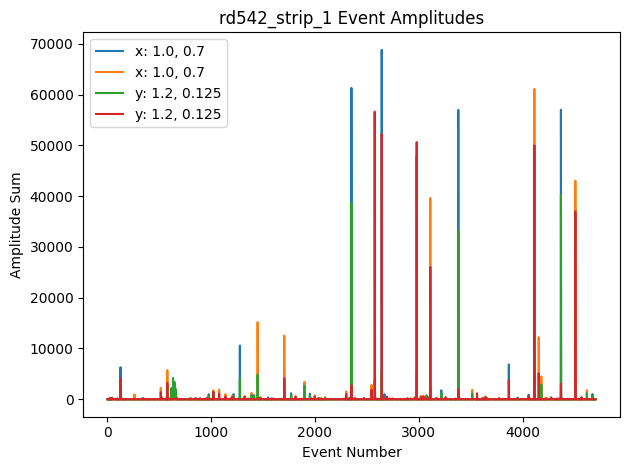

In [40]:
# det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

# if realign_dream:
#     det.center[2] = 722
#     det.add_rotation(90, 'z')

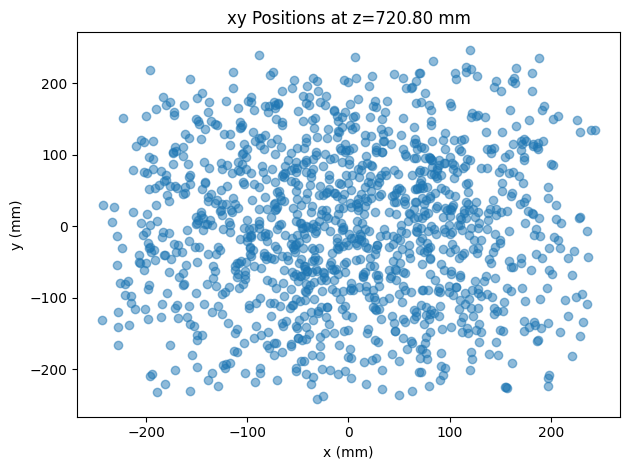

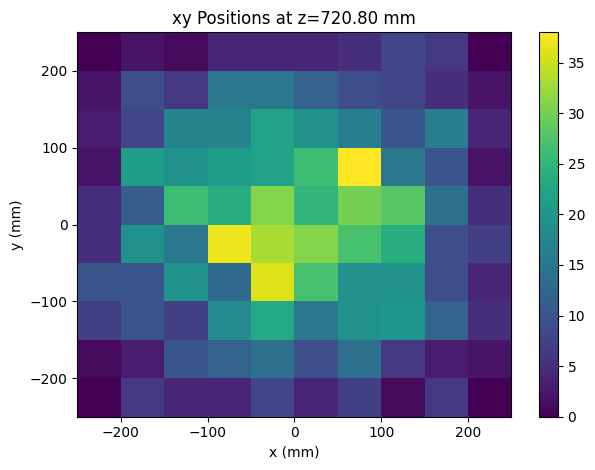

In [41]:
ray_data.plot_xy(det.center[2], plt_type='both', bins=10)

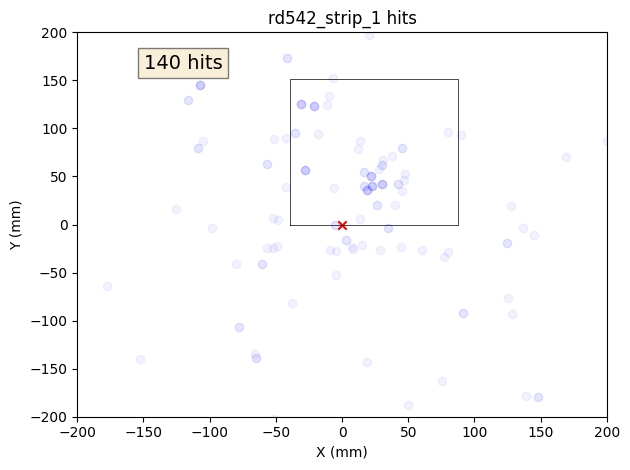

In [42]:
plot_ray_hits_2d(det, ray_data)

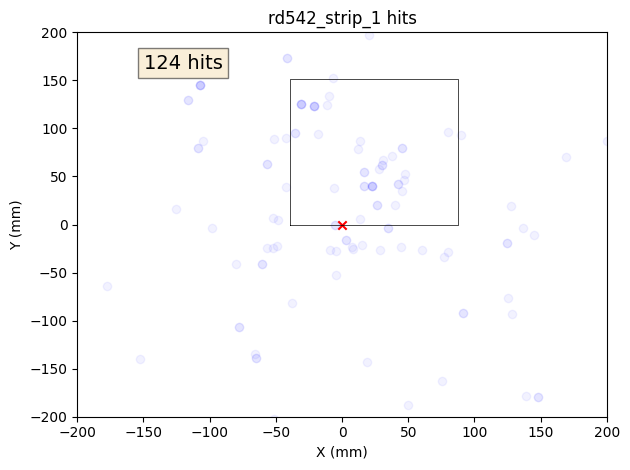

In [43]:
det.set_sub_det_event_filters(det.dream_data.event_nums[~spark_event_filter])
plot_ray_hits_2d(det, ray_data)

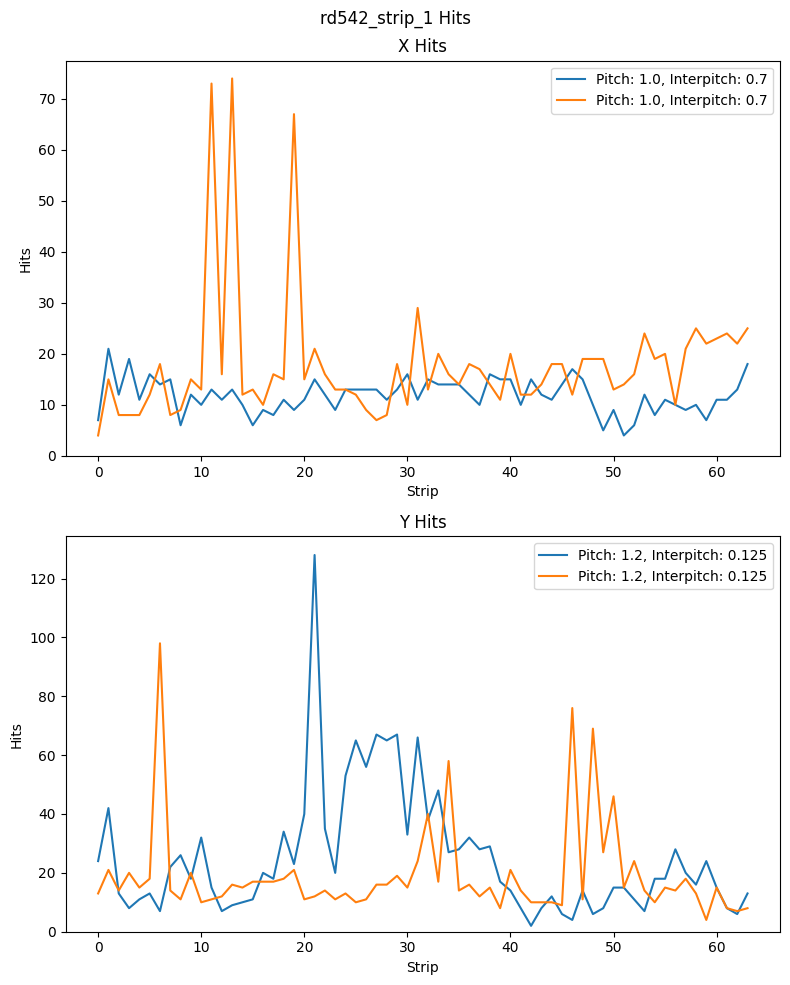

In [44]:
det.plot_hits_1d()

In [45]:
print(len(det.dream_data.hits))

4704


In [46]:
print(det.sub_detectors[0].x_hits.shape)
# print(len(det.sub_detectors[0].x_clusters))

(4704, 64)


In [47]:
print(len(ray_data.ray_data))

1247


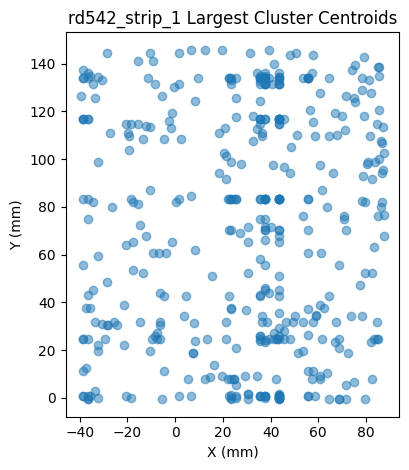

In [48]:
det.plot_centroids_2d()

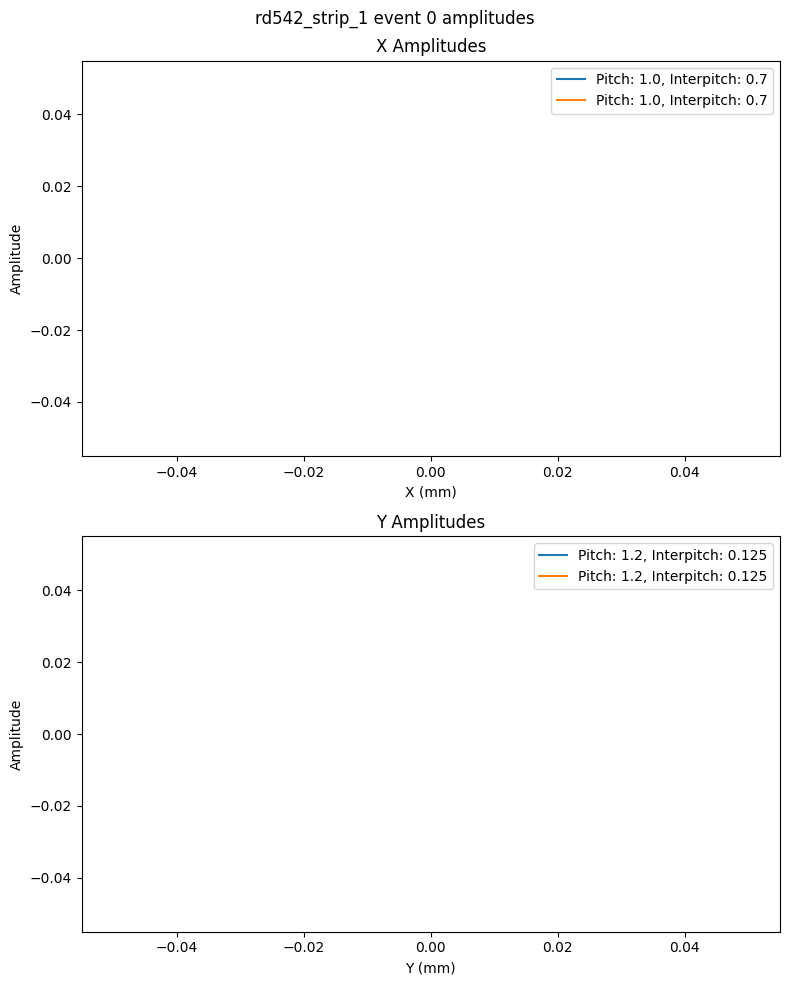

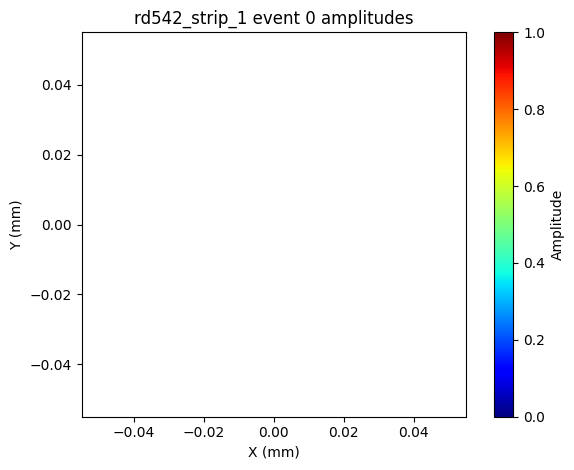

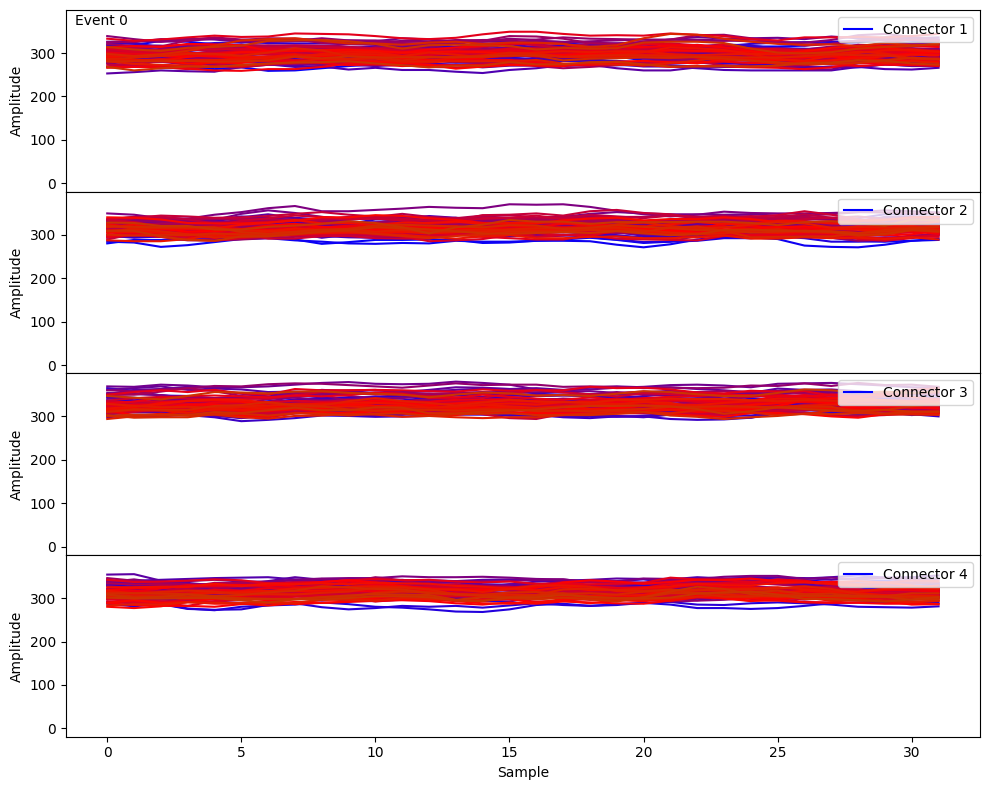

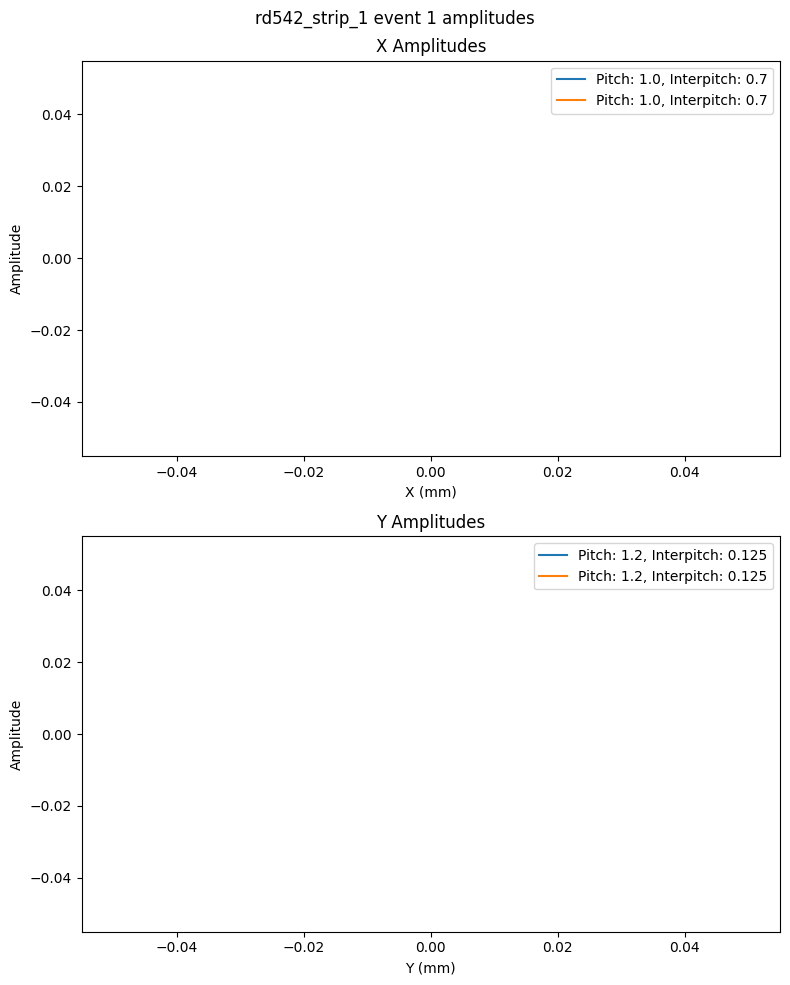

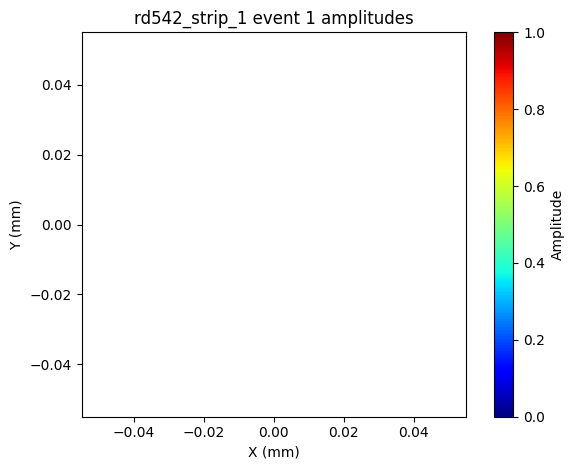

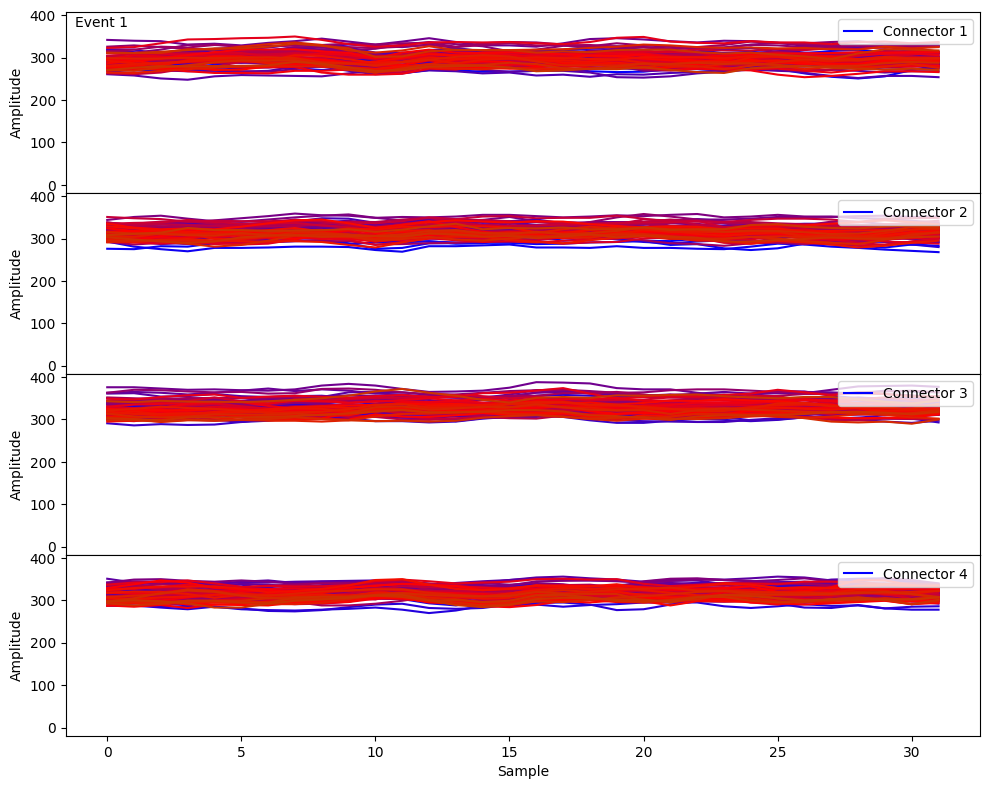

In [49]:
for event_num in range(min(len(det.dream_data.hits), 2)):
    det.plot_event_1d(event_num)
    det.plot_event_2d(event_num)
    det.dream_data.plot_waveforms(event_num)

z: 705.8
z: 706.8344827586207
z: 707.8689655172413
z: 708.903448275862
z: 709.9379310344827
z: 710.9724137931034
z: 712.0068965517241
z: 713.0413793103448
z: 714.0758620689654
z: 715.1103448275861
z: 716.1448275862068
z: 717.1793103448275
z: 718.2137931034482
z: 719.2482758620689
z: 720.2827586206896
z: 721.3172413793103
z: 722.351724137931
z: 723.3862068965517
z: 724.4206896551724
z: 725.4551724137931
z: 726.4896551724138
z: 727.5241379310345
z: 728.5586206896551
z: 729.5931034482758
z: 730.6275862068965
z: 731.6620689655172
z: 732.6965517241379
z: 733.7310344827586
z: 734.7655172413793
z: 735.8
z_rot: -2.0
z_rot: -1.8620689655172413
z_rot: -1.7241379310344827
z_rot: -1.5862068965517242
z_rot: -1.4482758620689655
z_rot: -1.3103448275862069
z_rot: -1.1724137931034484
z_rot: -1.0344827586206897
z_rot: -0.896551724137931
z_rot: -0.7586206896551724
z_rot: -0.6206896551724137
z_rot: -0.48275862068965525
z_rot: -0.3448275862068966
z_rot: -0.2068965517241379
z_rot: -0.06896551724137945
z_rot

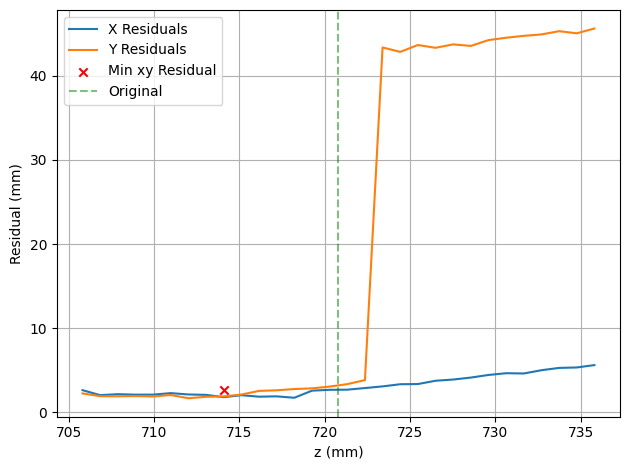

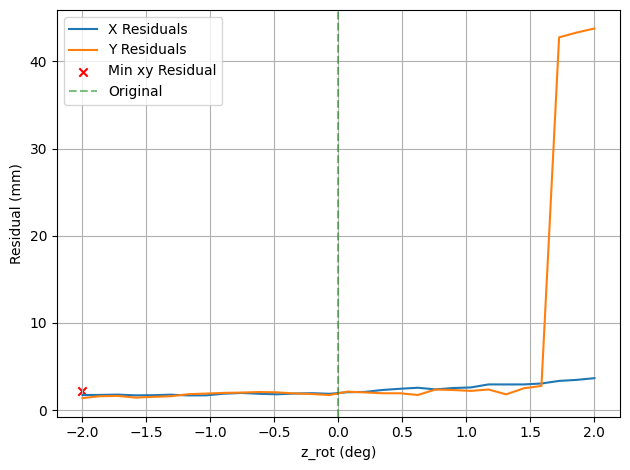

In [50]:
det.set_sub_det_event_filters(None)

z_orig = det.center[2]
x_bnds = det.center[0] - det.size[0] / 2, det.center[0] + det.size[0] / 2
y_bnds = det.center[1] - det.size[1] / 2, det.center[1] + det.size[1] / 2
ray_traversing_triggers = ray_data.get_traversing_triggers(z_orig, x_bnds, y_bnds, expansion_factor=0.1)

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    align_dream(det, ray_data, z_align_range, z_rot_align_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

z: 699.0758620689654
z: 700.1103448275861
z: 701.1448275862068
z: 702.1793103448275
z: 703.2137931034482
z: 704.2482758620689
z: 705.2827586206896
z: 706.3172413793103
z: 707.3517241379309
z: 708.3862068965516
z: 709.4206896551723
z: 710.455172413793
z: 711.4896551724137
z: 712.5241379310344
z: 713.5586206896551
z: 714.5931034482758
z: 715.6275862068965
z: 716.6620689655172
z: 717.6965517241379
z: 718.7310344827586
z: 719.7655172413793
z: 720.8
z: 721.8344827586207
z: 722.8689655172412
z: 723.9034482758619
z: 724.9379310344826
z: 725.9724137931033
z: 727.006896551724
z: 728.0413793103447
z: 729.0758620689654
z_rot: -2.0
z_rot: -1.8620689655172413
z_rot: -1.7241379310344827
z_rot: -1.5862068965517242
z_rot: -1.4482758620689655
z_rot: -1.3103448275862069
z_rot: -1.1724137931034484
z_rot: -1.0344827586206897
z_rot: -0.896551724137931
z_rot: -0.7586206896551724
z_rot: -0.6206896551724137
z_rot: -0.48275862068965525
z_rot: -0.3448275862068966
z_rot: -0.2068965517241379
z_rot: -0.06896551724

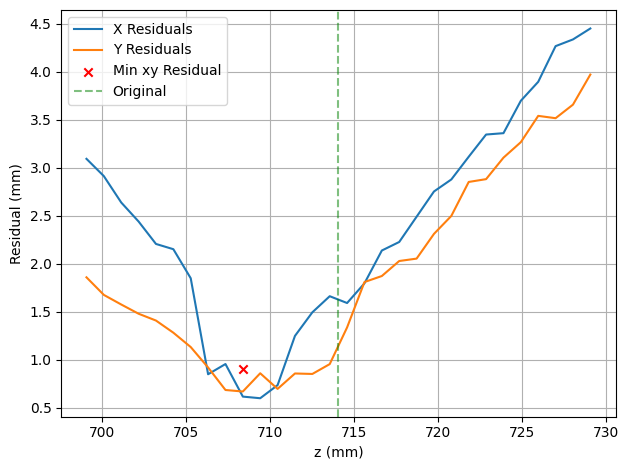

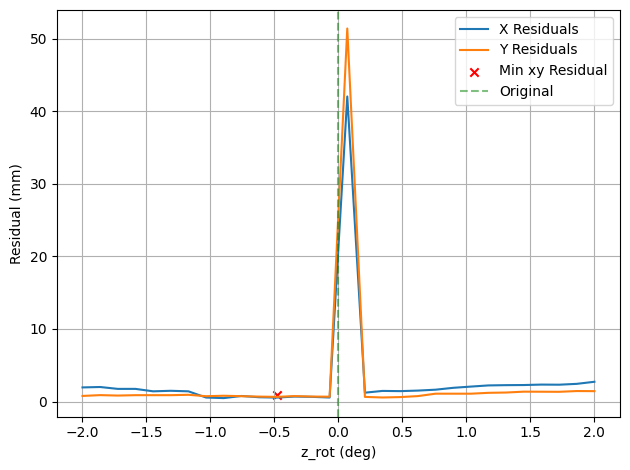

In [51]:
det.set_sub_det_event_filters(det.dream_data.event_nums[~spark_event_filter])

z_orig = det.center[2]
x_bnds = det.center[0] - det.size[0] / 2, det.center[0] + det.size[0] / 2
y_bnds = det.center[1] - det.size[1] / 2, det.center[1] + det.size[1] / 2
ray_traversing_triggers = ray_data.get_traversing_triggers(z_orig, x_bnds, y_bnds, expansion_factor=0.1)

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    align_dream(det, ray_data, z_align_range, z_rot_align_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

Text(-20, 0, 'Number of Spark Events: 9\nNumber of Good Rays for Spark Events: 4')

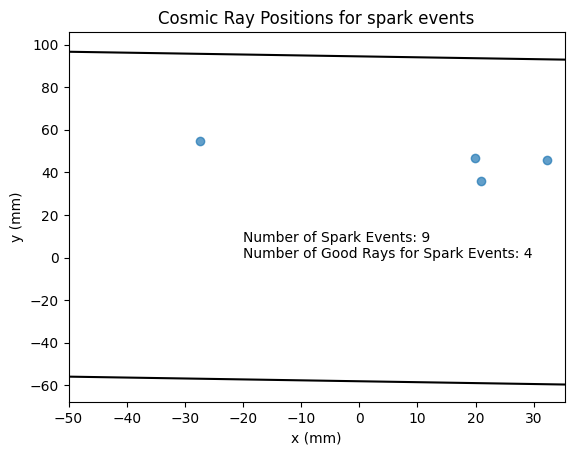

In [52]:
x_rays_spark, y_rays_spark, e_num_spark = ray_data.get_xy_positions(det.center[2], spark_event_nums)
fig, ax = plt.subplots()
ax.scatter(x_rays_spark, y_rays_spark, alpha=0.7)
ax.set_xlim()
corners = [[0, 0, 0], [0, det.active_size[1], 0], [det.active_size[0], det.active_size[1], 0], [det.active_size[0], 0, 0], [0, 0, 0]]
corners = det.convert_coords_to_global(corners)
ax.plot([corner[0] for corner in corners], [corner[1] for corner in corners], color='black', linewidth=1.5)
ax.set_xlim(left=-50)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_title('Cosmic Ray Positions for spark events')
ax.annotate(f'Number of Spark Events: {len(spark_event_nums)}\nNumber of Good Rays for Spark Events: {len(e_num_spark)}', (-20, 0))

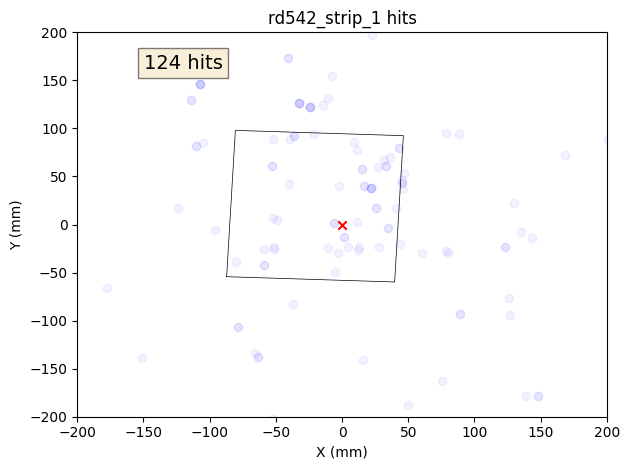

In [53]:
plot_ray_hits_2d(det, ray_data)

Pre-filtered rays: 1247
All rays: 318


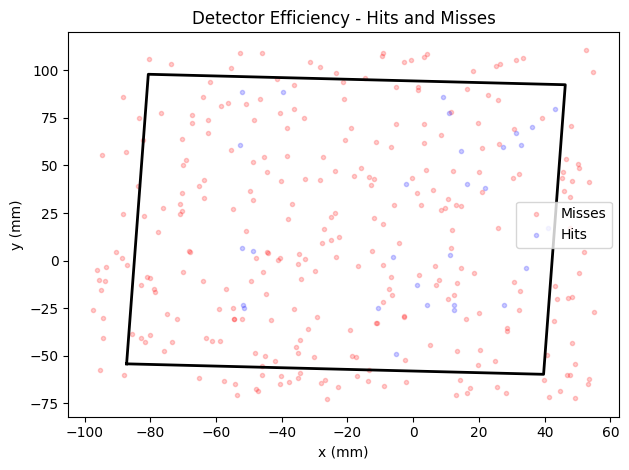

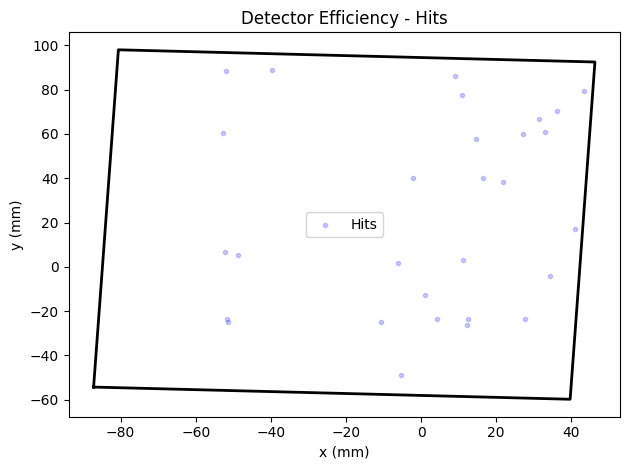

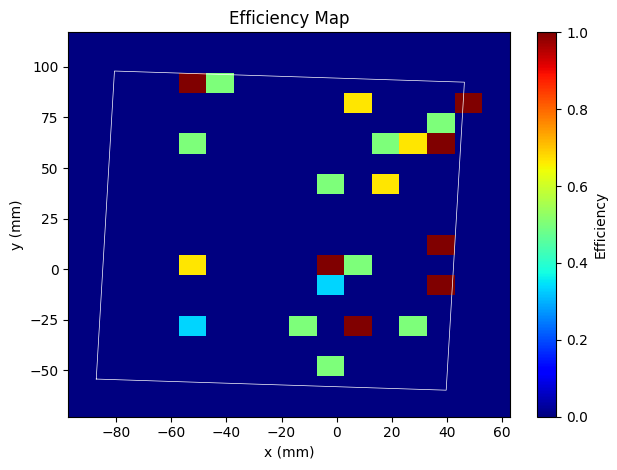

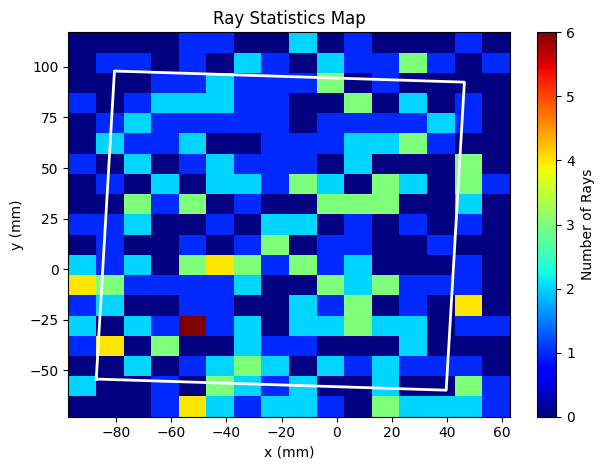

In [54]:
get_efficiency(det, ray_data, plot=True, in_det=True, tolerance=0.2, grid_size=10)

X Residuals: Mean=167μm, Std=744μm
Y Residuals: Mean=-477μm, Std=469μm
R Residuals: Mean=72101262μm


/local/home/dn277127/PycharmProjects/saclay_micromegas/poc/det_classes_test.py:1589: OptimizeWarning: Covariance of the parameters could not be estimated
  r_popt, r_pcov = cf(func, r_bins, r_counts, p0=p0)


(np.float64(-0.29855660774790865),
 np.float64(-0.45310828668438424),
 np.float64(0.4531105427239687),
 np.float64(0.6287735383808583))

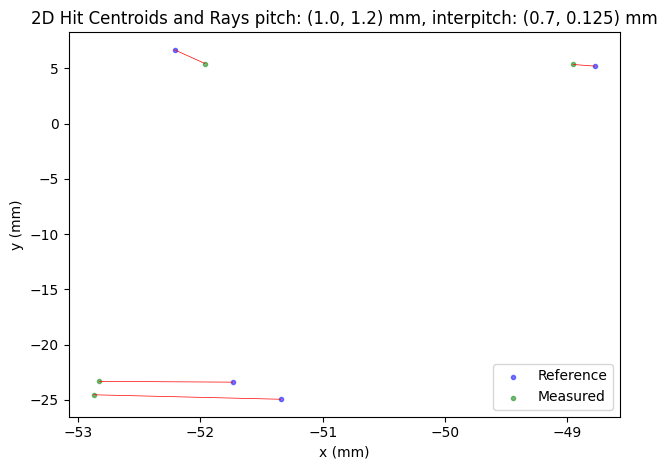

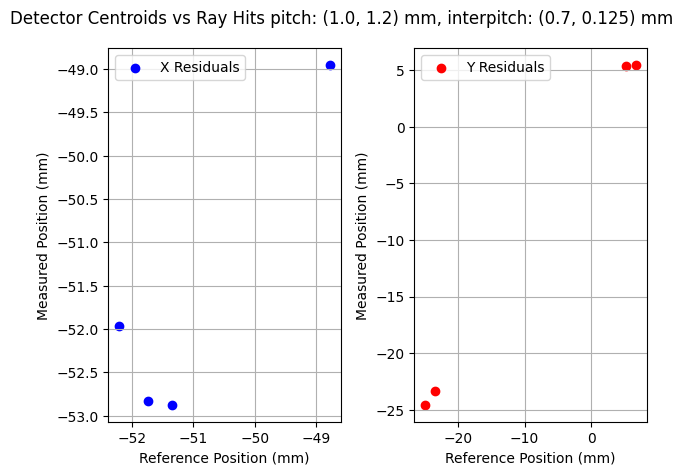

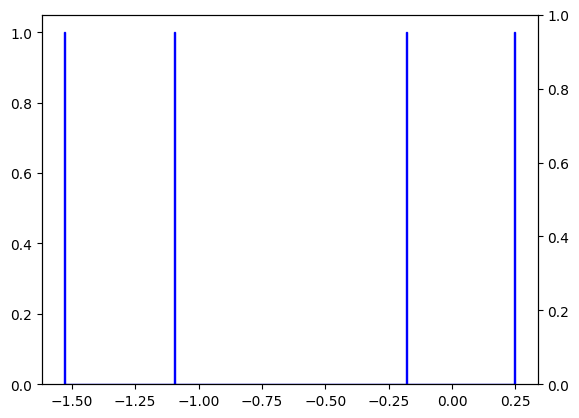

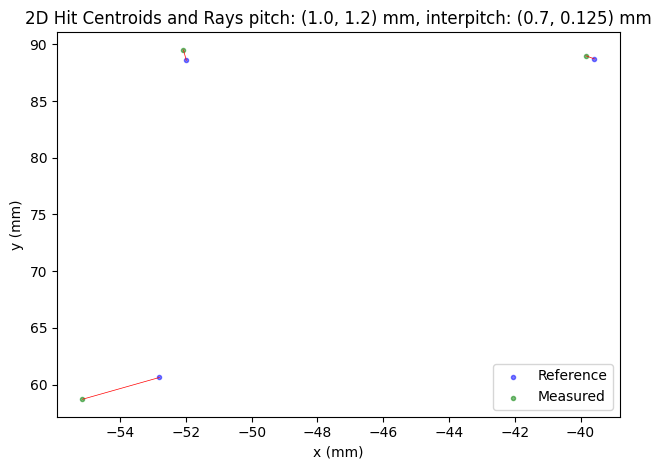

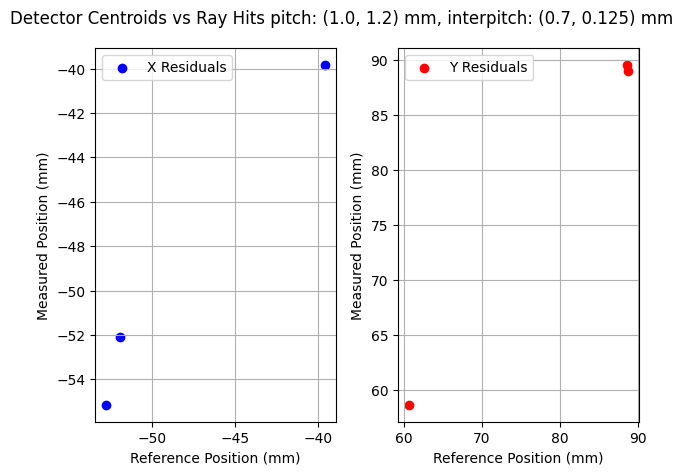

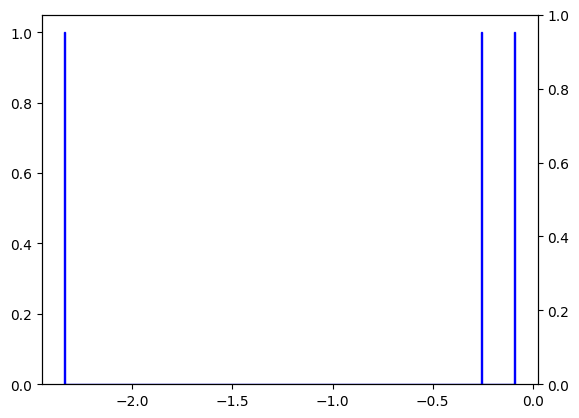

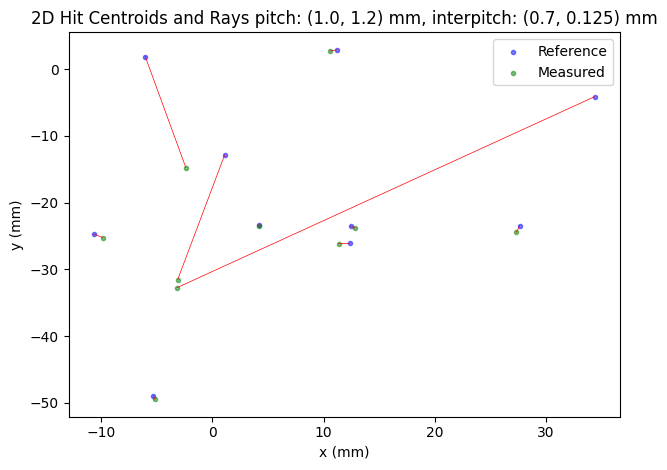

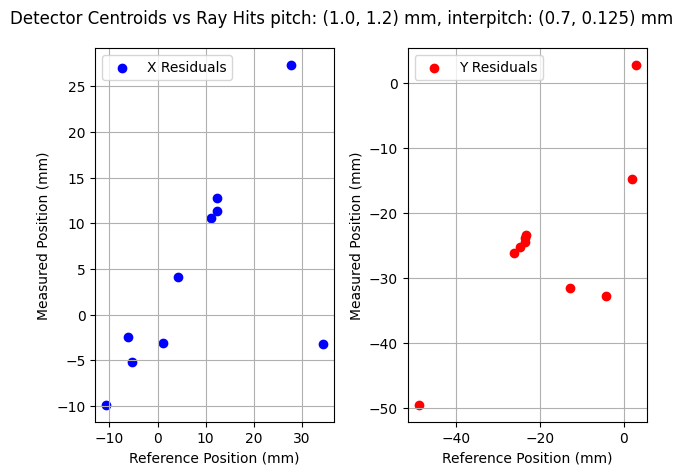

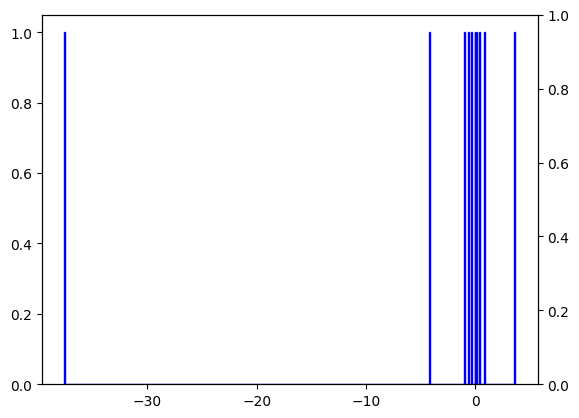

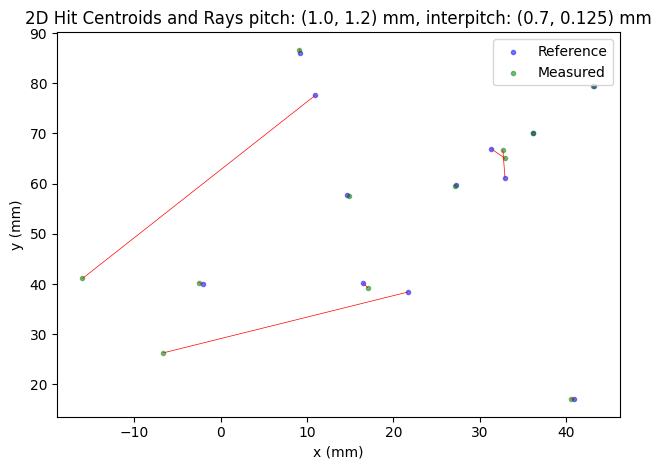

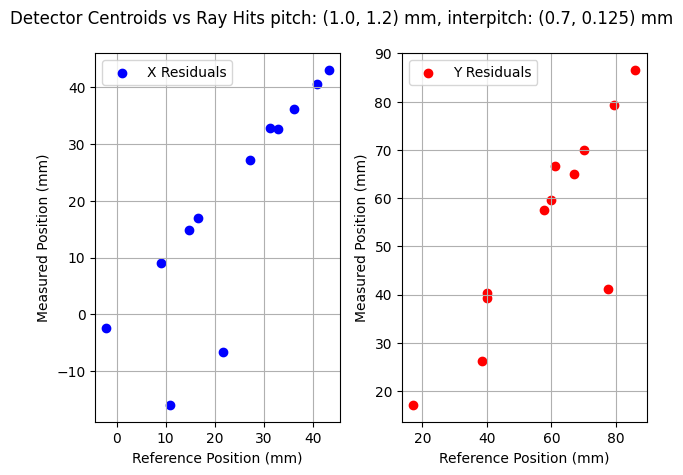

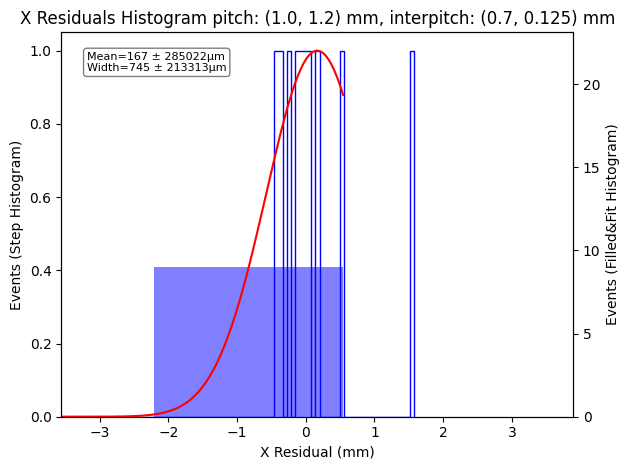

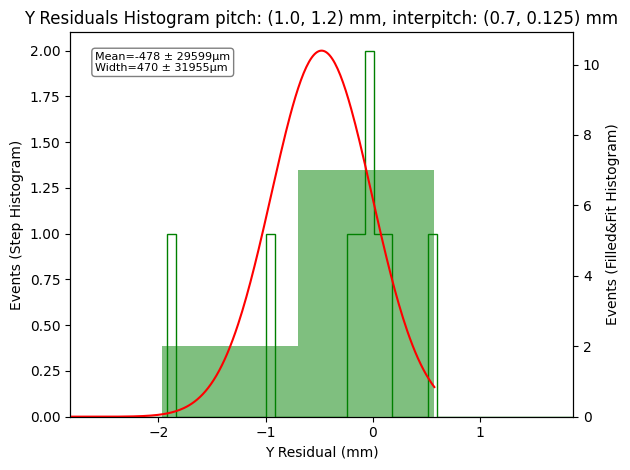

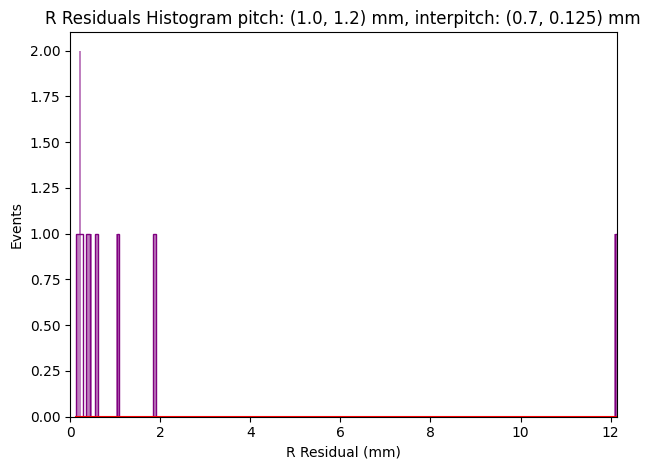

In [55]:
get_residuals(det, ray_data, plot=True, in_det=True, tolerance=0.2)

In [56]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2)

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean     x_mean_err  \
0      1.0      1.2           0.7         0.125 -1.348707  207176.819177   
1      1.0      1.2           0.7         0.125 -0.255249       0.000000   
2      1.0      1.2           0.7         0.125  0.222990       0.614292   
3      1.0      1.2           0.7         0.125 -0.106440       0.013167   

         y_mean    y_mean_err         x_std     x_std_err         y_std  \
0  1.343113e+01  3.581352e+06  1.119560e+02  1.604947e+07  1.343113e+01   
1  1.000000e-10  0.000000e+00  1.000000e-10  0.000000e+00  1.000000e-10   
2  7.272950e-01  4.113644e-01  9.195592e-01  5.819132e-01  7.272950e-01   
3  5.280496e-02  4.989088e-03  2.141053e-01  1.317291e-02  5.280496e-02   

      y_std_err  
0  3.581352e+06  
1  0.000000e+00  
2  4.113644e-01  
3  4.989088e-03  


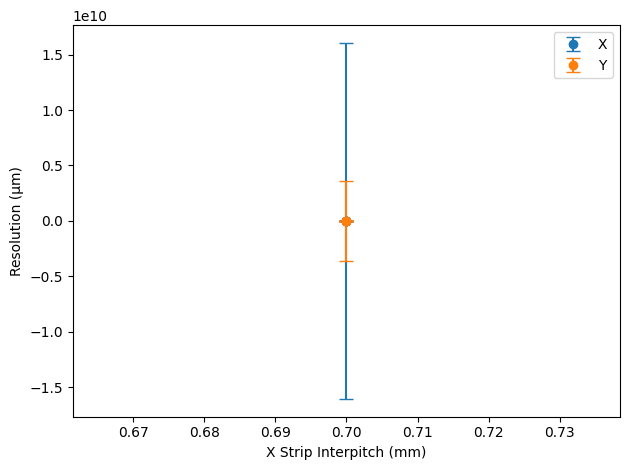

In [57]:
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

In [58]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:210: R

TypeError: 'NoneType' object is not subscriptable

New stuff above

In [ ]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

In [ ]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
pitches, x_means, x_errs, y_means, y_errs = [], [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=-2)
    print(f'Rays in sub-detector {sub_det.sub_index}: {len(x_rays_in)}, total rays: {len(x_rays)}')
    x_mean, y_mean, x_err, y_err = sub_det.plot_cluster_sizes(event_nums=event_num_rays_in)
    pitches.append(sub_det.x_interpitch)
    x_means.append(x_mean)
    x_errs.append(x_err)
    y_means.append(y_mean)
    y_errs.append(y_err)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(pitches, x_means, yerr=x_errs, fmt='o', capsize=5, label='X')
ax.errorbar(pitches, y_means, yerr=y_errs, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()
ax.plot(pitches, x_means, 'o', label='X')
ax.plot(pitches, y_means, 'o', label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [ ]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)

In [ ]:
scan_xs = np.arange(-40, 90, 1.0)
scan_ys = np.arange(-10, 160, 1.0)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs
scan_radius = 10  # mm
min_events = 30
# res_range = [160, 810]  # μm
# mean_range = [-200, 210]  # μm
res_range = None  # μm
mean_range = None  # μm

scan_resolutions_x, scan_means_x, events_x = get_circle_scan(np.array(x_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_x, scan_means_x, scan_xs, scan_ys, scan_events=events_x, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='X (Top) Spatial Resolution', mean_title='X (Top) Mean Residual', res_range=res_range, mean_range=mean_range)

In [ ]:
scan_resolutions_y, scan_means_y, events_y = get_circle_scan(np.array(y_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_y, scan_means_y, scan_xs, scan_ys, scan_events=events_y, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='Y (Bottom) Spatial Resolution', mean_title='Y (Bottom) Mean Residual', res_range=res_range, mean_range=mean_range)

In [ ]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)
scan_radius = 10
min_events = 20
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_sizes_all, y_sizes_all, x_rays_cluster_sizes, y_rays_cluster_sizes = [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=0)
    x_sizes, y_sizes, ray_mask = sub_det.get_cluster_sizes(largest=True, event_nums=event_num_rays_in, return_ray_mask=True)
    x_sizes_all.extend(x_sizes)
    y_sizes_all.extend(y_sizes)
    x_rays_cluster_sizes.extend(x_rays_in[ray_mask])
    y_rays_cluster_sizes.extend(y_rays_in[ray_mask])
scan_resolutions_csx, scan_means_csx, events_csx = get_circle_scan(np.array(x_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, shape='square', gaus_fit=False, min_events=min_events, plot=False)
plot_2D_circle_scan(scan_resolutions_csx, scan_means_csx, scan_xs, scan_ys, scan_events=events_csx, radius=scan_radius, percentile_filter=(1, 95), plot='mean', unit_str='N strips', mean_title='X Cluster Size')

In [ ]:
scan_resolutions_csy, scan_means_csy, events_csy = get_circle_scan(np.array(y_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), shape='square', gaus_fit=False, min_events=min_events, plot=False)
plot_2D_circle_scan(scan_resolutions_csy, scan_means_csy, scan_xs, scan_ys, scan_events=events_csy, radius=scan_radius, percentile_filter=(1, 99), plot='mean', unit_str='N strips', mean_title='Y Cluster Size')

In [ ]:
det.dream_data.correct_for_fine_timestamps()

sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, plot=True)
plt.title(f'Time of Max for X (Top) Strips')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips')

In [ ]:
min_amp = 600
sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for X (Top) Strips Min Amp {min_amp}')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips Min Amp {min_amp}')

In [ ]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_ray_angles, y_ray_angles, event_num_rays = ray_data.get_xy_angles()

in_det_mask = det.in_det_mask(x_rays, y_rays, np.full_like(x_rays, det.center[2]))

fig_x_angles, ax_x_angles = plt.subplots()
ax_x_angles.hist(np.rad2deg(x_ray_angles), bins=100)
ax_x_angles.hist(np.rad2deg(x_ray_angles[in_det_mask]), color='r', bins=100)
ax_x_angles.set_xlabel('Ray X Angles')

fig_y_angles, ax_y_angles = plt.subplots()
ax_y_angles.hist(np.rad2deg(y_ray_angles), bins=100)
ax_y_angles.hist(np.rad2deg(y_ray_angles[in_det_mask]), color='r', bins=100)
ax_y_angles.set_xlabel('Ray Y Angles')

In [ ]:
# min_amp = 0
# max_ray_angle = 8  # Degrees
# good_event_num_mask = np.isin(event_num_rays, det.dream_data.event_nums)
# x_rays_angles_filtered, y_ray_angles_filtered = x_ray_angles[good_event_num_mask], y_ray_angles[good_event_num_mask]
# ray_filter = (np.abs(x_rays_angles_filtered) < np.deg2rad(max_ray_angle)) & (np.abs(y_ray_angles_filtered) < np.deg2rad(max_ray_angle))
# sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=min_amp, event_filter=ray_filter, plot=True)
# plt.title(f'Time of Max for X (Top) Strips Min Amp {min_amp} & Max Ray Angle {max_ray_angle}°')
#
# sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=min_amp, event_filter=ray_filter, plot=True)
# plt.title(f'Time of Max for Y (Bottom) Strips Min Amp {min_amp} & Max Ray Angle {max_ray_angle}°')

In [ ]:
# min_amp = 350
# angles = np.arange(2, 20, 1)  # example: 2, 4, 6, 8 degrees
#
# sigma_x_vals, sigma_x_errs = [], []
# sigma_y_vals, sigma_y_errs = [], []
#
# for max_ray_angle in angles:
#     good_event_num_mask = np.isin(event_num_rays, det.dream_data.event_nums)
#     x_rays_angles_filtered = x_ray_angles[good_event_num_mask]
#     y_rays_angles_filtered = y_ray_angles[good_event_num_mask]
#
#     ray_filter = (
#         (np.abs(x_rays_angles_filtered) < np.deg2rad(max_ray_angle)) &
#         (np.abs(y_rays_angles_filtered) < np.deg2rad(max_ray_angle))
#     )
#
#     # --- X strips ---
#     sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(
#         max_channel=True,
#         channels=np.arange(0, int(256 / 2)),
#         min_amp=min_amp,
#         event_filter=ray_filter,
#         plot=False
#     )
#
#     sigma_x_vals.append(sigma_x)
#     sigma_x_errs.append(sigma_x_err)
#
#     # --- Y strips ---
#     sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(
#         max_channel=True,
#         channels=np.arange(int(256 / 2), 256),
#         min_amp=min_amp,
#         event_filter=ray_filter,
#         plot=False
#     )
#
#     sigma_y_vals.append(sigma_y)
#     sigma_y_errs.append(sigma_y_err)
#
# # --- summary plot ---
# plt.figure()
# plt.errorbar(angles, sigma_x_vals, yerr=sigma_x_errs, fmt='o-', label="X strips")
# plt.errorbar(angles, sigma_y_vals, yerr=sigma_y_errs, fmt='s-', label="Y strips")
# plt.xlabel("Max Ray Angle (degrees)")
# plt.ylabel("σ (Time of Max)")
# plt.title("σ vs Max Ray Angle")
# plt.legend()
# plt.show()


In [ ]:
x_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, filter_times=False)
x_time_maxes, x_time_filter = det.dream_data.filter_time_maxes(x_time_maxes, return_mask=True)
y_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, filter_times=False)
y_time_maxes, y_time_filter = det.dream_data.filter_time_maxes(y_time_maxes, return_mask=True)
time_ray_event_mask_x = np.isin(event_num_rays, det.dream_data.event_nums[x_time_filter])
time_ray_event_mask_y = np.isin(event_num_rays, det.dream_data.event_nums[y_time_filter])
x_rays_timing_x, y_rays_timing_x = x_rays[time_ray_event_mask_x], y_rays[time_ray_event_mask_x]
x_rays_timing_y, y_rays_timing_y = x_rays[time_ray_event_mask_y], y_rays[time_ray_event_mask_y]

In [ ]:
scan_radius = 10
min_events = 30
res_range = [20, 44]  # ns
mean_range = [405, 425]  # ns
scan_time_resolutions_x, scan_time_means_x, events_time_x = get_circle_scan(np.array(x_time_maxes), np.array(x_rays_timing_x), np.array(y_rays_timing_x), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_x, scan_time_means_x, scan_xs, scan_ys, scan_events=events_time_x, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution X (Top) Strips', mean_title='Mean Time X (Top) Strips', res_range=res_range, mean_range=mean_range)

In [ ]:
scan_time_resolutions_y, scan_time_means_y, events_time_y = get_circle_scan(np.array(y_time_maxes), np.array(x_rays_timing_y), np.array(y_rays_timing_y), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_y, scan_time_means_y, scan_xs, scan_ys, scan_events=events_time_y, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution Y (Bottom) Strips', mean_title='Mean Time Y (Bottom) Strips', res_range=res_range, mean_range=mean_range)

In [ ]:
channel_nums = np.arange(27, 127, 1)
min_amp = 600
time_resolutions_x, time_resolutions_errs_x = [], []
for channel_num in channel_nums:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=[channel_num], min_amp=min_amp, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
fig, ax = plt.subplots()
ax.errorbar(channel_nums, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution for X (Top) Strips, Min Amp {min_amp}')
fig.tight_layout()

In [ ]:
channel_nums = np.arange(155, 256, 1)
min_amp, max_amp = 600, 3500
time_resolutions_y, time_resolutions_errs_y = [], []
for channel_num in channel_nums:
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=[channel_num], min_amp=min_amp, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
ax.errorbar(channel_nums, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution for Y (Bottom) Strips, Min Amp {min_amp}')
fig.tight_layout()

In [ ]:
min_amps = np.arange(0, 3000, 50)
time_resolutions_x, time_resolutions_errs_x = [], []
time_resolutions_y, time_resolutions_errs_y = [], []
for min_amp_i in min_amps:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, 128), min_amp=min_amp_i, max_amp=3500, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(129, 256), min_amp=min_amp_i, max_amp=3500, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
ax.errorbar(min_amps, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5, label='X (Top) Strips')
ax.errorbar(min_amps, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5, label='Y (Bottom) Strips')
ax.set_xlabel('Minimum Amplitude Cut')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution vs Min Amplitude Cut')
ax.legend()
fig.tight_layout()

In [ ]:
min_amps = np.arange(0, 2600, 50)
amp_range = 50
time_resolutions_x, time_resolutions_errs_x = [], []
time_resolutions_y, time_resolutions_errs_y = [], []
for min_amp_i in min_amps:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, 128), min_amp=min_amp_i, max_amp=min_amp_i + amp_range, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(129, 256), min_amp=min_amp_i, max_amp=min_amp_i + amp_range, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
mid_amps = min_amps + amp_range / 2
ax.errorbar(mid_amps, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5, label='X (Top) Strips')
ax.errorbar(mid_amps, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5, label='Y (Bottom) Strips')
ax.set_xlabel('Minimum Amplitude Cut')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution vs Amplitude ({amp_range}ns window)')
ax.legend()
fig.tight_layout()

In [ ]:
edge_cushion = 5 # mm
det_z = det.center[2]
for sub_det in det.sub_detectors:
    x_min_loc, x_max_loc = np.min(sub_det.x_pos), np.max(sub_det.x_pos)
    y_min_loc, y_max_loc = np.min(sub_det.y_pos), np.max(sub_det.y_pos)
    top_left, top_right = (x_min_loc, y_max_loc, det_z), (x_max_loc, y_max_loc, det_z)
    bottom_left, bottom_right = (x_min_loc, y_min_loc, det_z), (x_max_loc, y_min_loc, det_z)
    top_left, top_right = det.convert_coords_to_global(top_left), det.convert_coords_to_global(top_right)
    bottom_left, bottom_right = det.convert_coords_to_global(bottom_left), det.convert_coords_to_global(bottom_right)
    print(f'Sub-detector {sub_det.sub_index} corners:')
    print(f'Top Left: {top_left}, Top Right: {top_right}, Bottom Left: {bottom_left}, Bottom Right: {bottom_right}')
